In [10]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

from scipy.spatial.distance import braycurtis

import imports

In [11]:
data_d = pd.read_csv(r"train_data.csv", index_col="sample")
meta_d = pd.read_csv(r"train_metadata.csv",  index_col="sample")

## graph 1

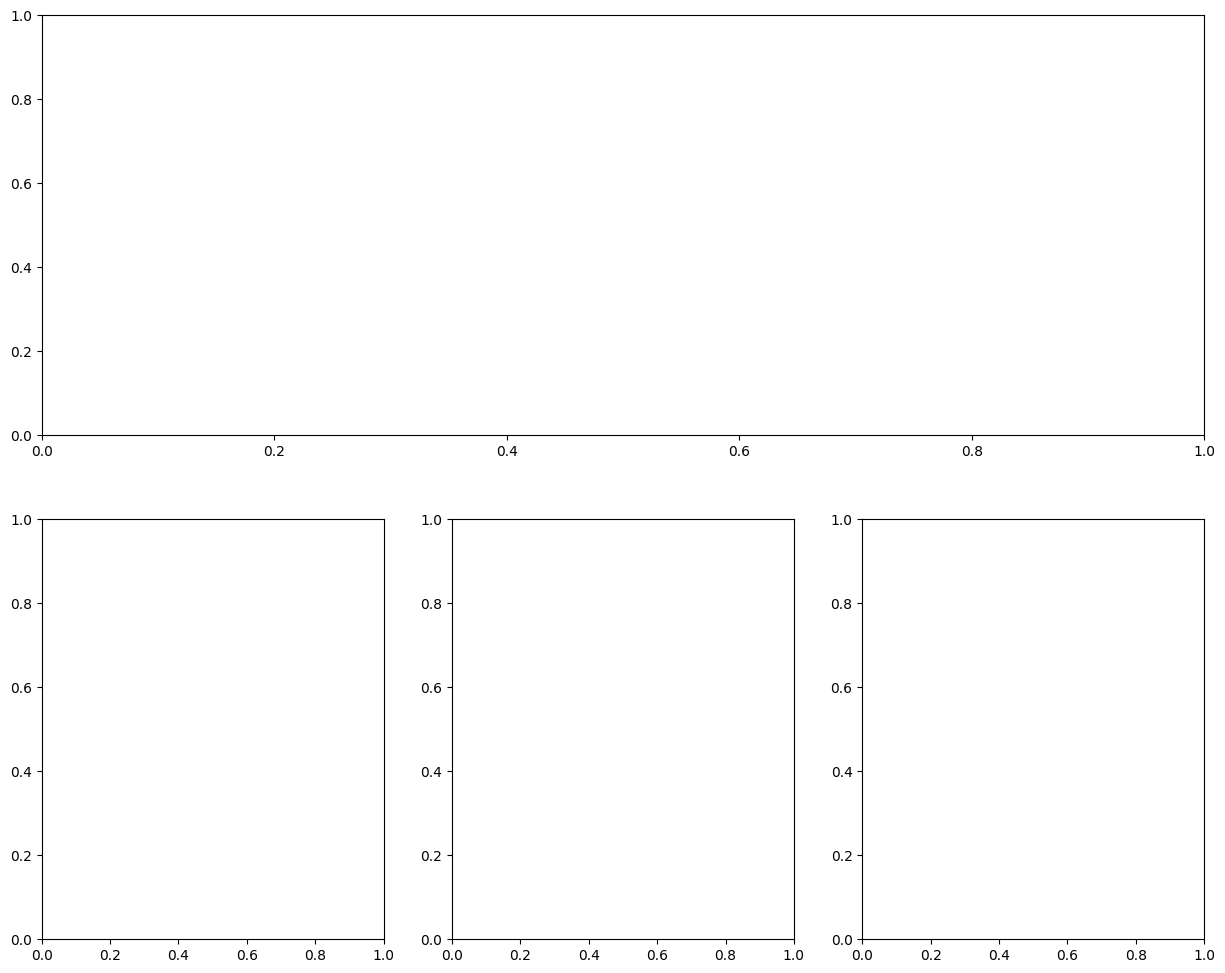

In [12]:
fig,axes = plt.subplot_mosaic([['a', 'a' ,'a'],
                               ["b",'c', 'd']])
fig.set_size_inches(15, 12)

In [13]:
# time difference histogram
data_df = data_d.copy()
metadata_df =meta_d.copy()
metadata_df["collection_date"] = (pd.to_datetime(metadata_df['collection_date']) - pd.Timestamp('1970-01-01')).dt.days
metadata_df.sort_values(by=["baboon_id", "collection_date"], inplace=True)
ds = []
for baboon in metadata_df["baboon_id"].unique():
    curr = metadata_df[metadata_df["baboon_id"] == baboon]["collection_date"].values
   
    for i in range(len(curr)-1):
        ds.append(curr[i+1]-curr[i])
        
ds = np.array(ds)


In [14]:
sns.histplot(ds, ax=axes['a'])
for i in range(365//2, max(ds), 365//2):
    axes['a'].vlines(x=i, ymin=0, ymax=1000, color="black")


axes['a'].set_xlabel("Time Difference (Days)")
axes['a'].set_yscale("log")
axes['a'].set_title("Time Difference Between Consecutive Samples")
axes['a'].text(0, 1.05, 'a', transform=axes['a'].transAxes,
               fontsize=14, fontweight='bold', va='top', ha='right')


Text(0, 1.05, 'a')

In [15]:
### Same day histogram
data_df = data_d.copy()
metadata_df =meta_d.copy()
indexes_list = []
visited = set()

for index, row in metadata_df.iterrows():
    if not (index in visited):
        collection_date = row['collection_date']
        baboon_id = row['baboon_id']
        matching_indexes = metadata_df[(metadata_df['collection_date'] == collection_date) & (metadata_df['baboon_id'] == baboon_id)].index.tolist()
        visited.update(matching_indexes)

    indexes_list.append(matching_indexes)
indexes_list = [list(l) for l in dict.fromkeys([tuple(sorted(indexes)) for indexes in indexes_list])]
indexes_list = [index for index in indexes_list if len(index) > 1]

bray_curtis_distances = []

for indexes in indexes_list:
    for row1 in data_df.loc[indexes].iterrows():
        for row2 in data_df.loc[indexes].iterrows():
            if row1[0] != row2[0]:
                distance = braycurtis(row1[1], row2[1])
                bray_curtis_distances.append(distance)

bray_curtis_distances = np.array(bray_curtis_distances)
sns.kdeplot(bray_curtis_distances, ax=axes['b'])
axes['b'].set_xlabel("Bray Curtis Distance")
axes['b'].set_ylabel("Density")

axes['b'].vlines(x = bray_curtis_distances.mean(), ymin=0, ymax=4.5, color="red", label=f"mean ({np.around(np.mean(bray_curtis_distances),3)})")
axes['b'].vlines(x = np.median(bray_curtis_distances), ymin=0, ymax=4.5, color="green", label=f"median ({np.around(np.quantile(bray_curtis_distances, 0.5),3)})")



lower_bound = np.quantile(bray_curtis_distances, 0.025)
upper_bound = np.quantile(bray_curtis_distances, 0.975)

axes['b'].vlines(x = lower_bound, ymin=0, ymax=4.5, color="blue", label="95% CI")
axes['b'].vlines(x = upper_bound, ymin=0, ymax=4.5, color="blue")


axes['b'].text(-0.05, 1.05, 'b', transform=axes['b'].transAxes,
               fontsize=14, fontweight='bold', va='top', ha='right')
axes['b'].set_title("Bray- Curtis KDE", fontsize=12)
axes['b'].legend(loc='upper right')


In [16]:
### mean of previous histogram
data_df = data_d.copy()
metadata_df =meta_d.copy()

metadata_df["collection_date"] = (pd.to_datetime(metadata_df['collection_date']) - pd.Timestamp('1970-01-01')).dt.days
microbiom_with_sample_data = data_df.join(metadata_df[["baboon_id", "collection_date"]], how="inner")
microbiom_with_sample_data = microbiom_with_sample_data.sort_values(["baboon_id", "collection_date"])



bc_scores = []
for baboon in metadata_df["baboon_id"].unique():
    baboon_samples = microbiom_with_sample_data[microbiom_with_sample_data["baboon_id"]==baboon].index
    for i in range(1, len(baboon_samples)):
        mean_previous = data_df.loc[baboon_samples[0:i]].mean().values
        bc_scores.append(braycurtis(mean_previous, data_df.loc[baboon_samples[i]].values))
bc_scores = np.array(bc_scores)

sns.kdeplot(bc_scores, ax=axes['c'])
axes['c'].set_xlabel("Bray Curtis Distance")
axes['c'].set_ylabel("Density")
axes['c'].set_title("Bray Curtis KDE", fontsize=12)
axes['c'].vlines(x = bc_scores.mean(), ymin=0, ymax=3.5, color="red",label=f"mean ({np.around(np.mean(bc_scores),3)})")
axes['c'].vlines(x = np.median(bc_scores) , ymin=0, ymax=3.5, color="green", label=f"median ({np.around(np.quantile(bc_scores, 0.5),3)})")


lower_bound = np.quantile(bc_scores, 0.025)
upper_bound = np.quantile(bc_scores, 0.975)

axes['c'].vlines(x = lower_bound, ymin=0, ymax=3.5, color="blue", label="95% CI")
axes['c'].vlines(x = upper_bound, ymin=0, ymax=3.5, color="blue")
axes['c'].text(-0.05, 1.05, 'c', transform=axes['c'].transAxes,
               fontsize=14, fontweight='bold', va='top', ha='right')
axes['c'].legend(loc='upper right')

In [17]:
#sample vs prev
data_df = data_d.copy()
metadata_df =meta_d.copy()

metadata_df["collection_date"] = (pd.to_datetime(metadata_df['collection_date']) - pd.Timestamp('1970-01-01')).dt.days
microbiom_with_sample_data = data_df.join(metadata_df[["baboon_id", "collection_date"]], how="inner")
microbiom_with_sample_data = microbiom_with_sample_data.sort_values(["baboon_id", "collection_date"])

bc_scores = []
for baboon in metadata_df["baboon_id"].unique():
    baboon_samples = microbiom_with_sample_data[microbiom_with_sample_data["baboon_id"]==baboon].index
    for i in range(1, len(baboon_samples)):
        bc_scores.append(braycurtis(data_df.loc[baboon_samples[i-1]], data_df.loc[baboon_samples[i]].values))
bc_scores = np.array(bc_scores)

sns.kdeplot(bc_scores, ax=axes['d'])
axes['d'].set_xlabel("Bray Curtis Distance")
axes['d'].set_ylabel("Density")
axes['d'].set_title("Bray Curtis KDE", fontsize=12)
axes['d'].vlines(x = bc_scores.mean(), ymin=0, ymax=2.5, color="red",label=f"mean ({np.around(np.mean(bc_scores),3)})")
axes['d'].vlines(x = np.median(bc_scores) , ymin=0, ymax=2.5, color="green", label=f"median ({np.around(np.quantile(bc_scores, 0.5),3)})")


lower_bound = np.quantile(bc_scores, 0.025)
upper_bound = np.quantile(bc_scores, 0.975)

axes['d'].vlines(x = lower_bound, ymin=0, ymax=2.5, color="blue", label="95% CI")
axes['d'].vlines(x = upper_bound, ymin=0, ymax=2.5, color="blue")
axes['d'].text(-0.05, 1.05, 'd', transform=axes['d'].transAxes,
               fontsize=14, fontweight='bold', va='top', ha='right')
axes['d'].legend(loc='upper right')
plt.show()

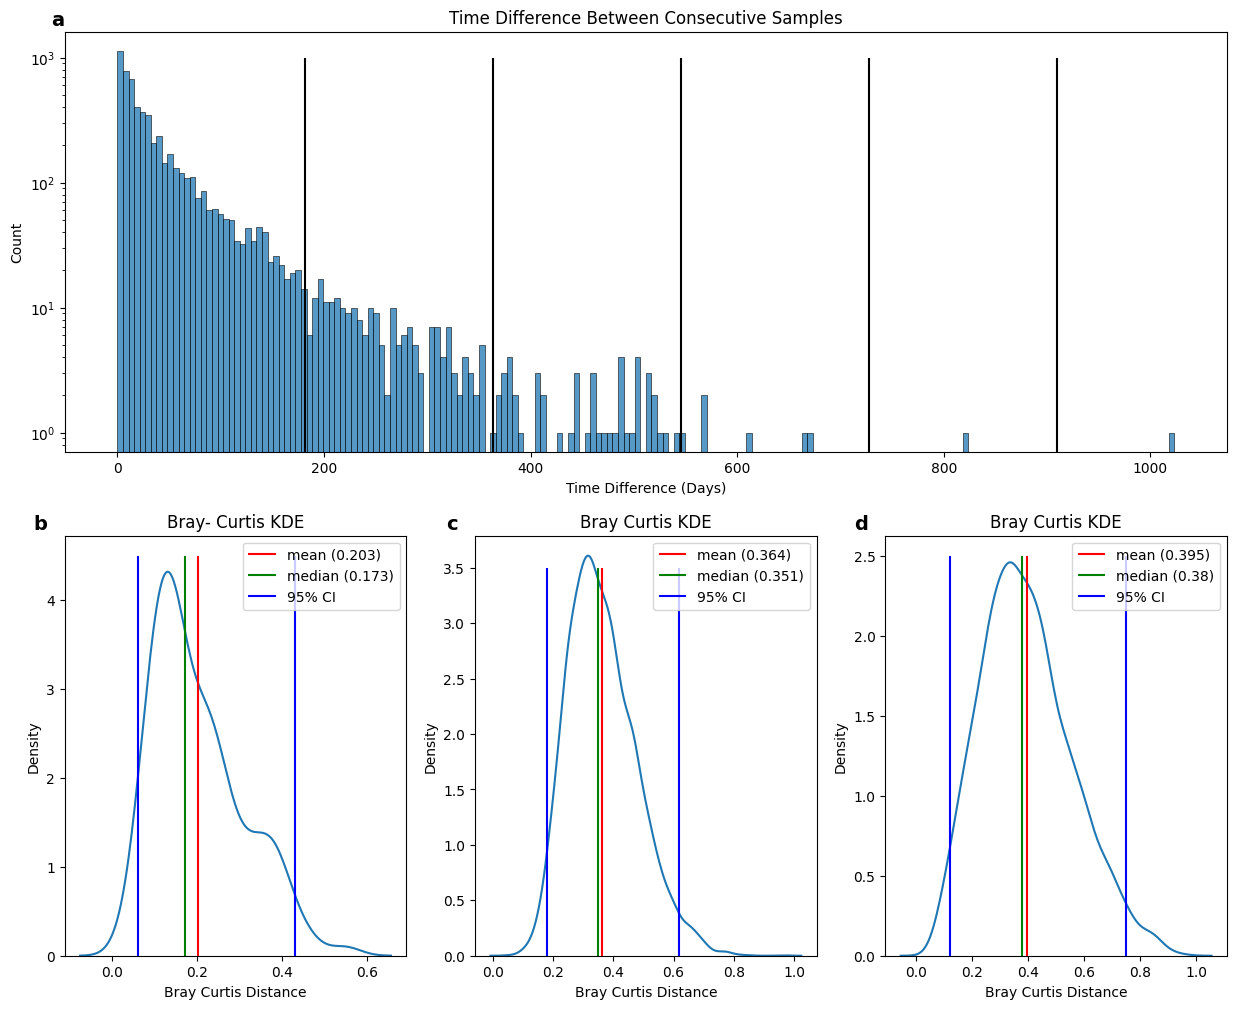

In [18]:
fig